# **Generación de Datos para las Ecuaciones de Aguas Poco Profundas en 2D (Forma no conservativa)**

En este código se construyen los conjuntos de entrenamiento y testeo para la ecuación shallow water, resolviendo a partir de una condición inicial y retornando su solución en el tiempo $T$.

---

Sean $h(x, y, t)$ la altura de la columna de agua, $u(x, y, t)$ y $v(x, y, t)$ las velocidades horizontales en las direcciones $x$ e $y$, respectivamente, y $g$ la aceleración de la gravedad.

El sistema no lineal en forma no conservativa es:

$$
\begin{align}
\frac{\partial h}{\partial t} + u \frac{\partial h}{\partial x} + v \frac{\partial h}{\partial y} + h \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) &= 0 \\
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + g \frac{\partial h}{\partial x} &= 0 \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + g \frac{\partial h}{\partial y} &= 0
\end{align}
$$

## **Condiciones de borde periódicas**

Para un dominio rectangular $(x, y) \in [0, L_x] \times [0, L_y]$, se imponen las condiciones:

$$
\begin{align}
h(0, y, t) &= h(L_x, y, t), &\quad h(x, 0, t) &= h(x, L_y, t) \\
u(0, y, t) &= u(L_x, y, t), &\quad u(x, 0, t) &= u(x, L_y, t) \\
v(0, y, t) &= v(L_x, y, t), &\quad v(x, 0, t) &= v(x, L_y, t)
\end{align}
$$

## **Ecuaciones de Aguas Poco Profundas en 2D (Forma vectorial)**

Sea $\mathbf{u}(x, y, t) = \begin{pmatrix} u(x,y,t) \\ v(x,y,t) \end{pmatrix}$ el campo de velocidades horizontales y $h(x, y, t)$ la altura de la columna de agua. Las ecuaciones en forma vectorial son:

$$
\begin{align}
\frac{\partial h}{\partial t} + \mathbf{u} \cdot \nabla h + h \nabla \cdot \mathbf{u} &= 0 \\
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} + g \nabla h &= \mathbf{0}
\end{align}
$$

donde:

- $\nabla = \left( \frac{\partial}{\partial x}, \frac{\partial}{\partial y} \right)$
- $\nabla \cdot \mathbf{u} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}$
- $(\mathbf{u} \cdot \nabla)\mathbf{u} = u \frac{\partial \mathbf{u}}{\partial x} + v \frac{\partial \mathbf{u}}{\partial y}$

## **Condiciones de borde periódicas**

Para $(x, y) \in [0, L_x] \times [0, L_y]$, se tiene:

$$
\begin{align}
h(0, y, t) &= h(L_x, y, t), &\quad h(x, 0, t) &= h(x, L_y, t) \\
\mathbf{u}(0, y, t) &= \mathbf{u}(L_x, y, t), &\quad \mathbf{u}(x, 0, t) &= \mathbf{u}(x, L_y, t)
\end{align}
$$

In [16]:
# Importar Librerías
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from neuralop.losses.finite_diff import central_diff_2d


start_time= time.time()

In [17]:
# Definición de parámetros

# Espaciales
Lx, Ly = 1.0, 1.0
nx, ny = 128, 128
dx, dy = Lx / nx, Ly / ny
x = torch.linspace(0, Lx, nx)
y = torch.linspace(0, Ly, ny)
X, Y = torch.meshgrid(x, y, indexing='ij')

# Temporales
dt = 1e-5                                     
nt = 30000                     
               
# Aceleración de Gravedad
g = 9.81

# Tamaño del Batch
batch_size = 32

In [18]:
# Crear directorio para guardar datos
data_dir = Path("../data/shallow_water_data")
data_dir.mkdir(parents=True, exist_ok=True)

## **Solver usando Diferencias Finitas**

In [19]:
# Condiciones iniciales con batch
def initial_conditions(batch_size):
    h = torch.ones(batch_size, nx, ny)
    u = torch.zeros_like(h)
    v = torch.zeros_like(h)
    x_center = torch.rand(batch_size, 1, 1, dtype=X.dtype, device=X.device) #* torch.pi
    y_center = torch.rand(batch_size, 1, 1, dtype=Y.dtype, device=Y.device) #* torch.pi
    for b in range(batch_size):
        h[b] += 0.2 * torch.exp(-100 * ((X - x_center[b])**2 + (Y - y_center[b])**2))
        u[b] += 0.2 #* torch.sin(2 * torch.pi * X) * torch.sin(2 * torch.pi * Y)
        v[b] += 0.1 #* torch.cos(2 * torch.pi * X) * torch.cos(2 * torch.pi * Y)
    return h, u, v

# Derivadas centradas con condiciones periódicas
def ddx(f):
    return (torch.roll(f, -1, dims=1) - torch.roll(f, 1, dims=1)) / (2 * dx)

def ddy(f):
    return (torch.roll(f, -1, dims=2) - torch.roll(f, 1, dims=2)) / (2 * dy)

# Paso temporal
def step(h, u, v):
    dhdt = - (u * ddx(h) + v * ddy(h) + h * (ddx(u) + ddy(v)))
    dudt = - (u * ddx(u) + v * ddy(u)) - g * ddx(h)
    dvdt = - (u * ddx(v) + v * ddy(v)) - g * ddy(h)
    return h + dt * dhdt, u + dt * dudt, v + dt * dvdt

## **Generación de Datos de Entrenamiento**

Para construir los conjuntos de entrenamiento y test debemos generar pares $a_j$ y $u_j$ con la estructura adecuada. Consideraremos 1024 pares de entrenamiento y 192 pares de test con paquetes de tamaño 32 (*batch_size*)

En este caso $a_j$ será la condición inicial aleatoria definida anteriomente sobre una malla de $(nx,ny)$ puntos y $u_j$ es la solución de la EDP en el tiempo final $T$.

In [5]:
N_train = 1024

a = torch.zeros(N_train, nx, ny)  
u = torch.zeros(N_train, nx, ny) 

i = 0
for j in range(N_train // batch_size):
    print(f"Batch {j}/{N_train // batch_size}")

    # Generar condiciones iniciales
    h, u_, v_ = initial_conditions(batch_size)

    # Guardar h0
    a[i:i+batch_size, ...] = h

    # Evolución temporal
    for t in range(nt):
        h, u_, v_ = step(h, u_, v_)

    # Guardar h final
    u[i:i+batch_size, ...] = h

    i += batch_size

# Guardar el dataset
torch.save({"x": a, "y": u}, data_dir / f"shallow_water_train_{nx}.pt")
print(f"Datos guardados en '{data_dir / f'shallow_water_train_{nx}.pt'}'")

Batch 0/32
Batch 1/32
Batch 2/32
Batch 3/32
Batch 4/32
Batch 5/32
Batch 6/32
Batch 7/32
Batch 8/32
Batch 9/32
Batch 10/32
Batch 11/32
Batch 12/32
Batch 13/32
Batch 14/32
Batch 15/32
Batch 16/32
Batch 17/32
Batch 18/32
Batch 19/32
Batch 20/32
Batch 21/32
Batch 22/32
Batch 23/32
Batch 24/32
Batch 25/32
Batch 26/32
Batch 27/32
Batch 28/32
Batch 29/32
Batch 30/32
Batch 31/32
Datos guardados en '..\data\shallow_water_data\shallow_water_train_128.pt'


## **Generación de Datos de Testeo**

In [6]:
N_test = 192

a = torch.zeros(N_test, nx, ny)  
u = torch.zeros(N_test, nx, ny) 

i = 0
for j in range(N_test // batch_size):
    print(f"Batch {j}/{N_train // batch_size}")

    # Generar condiciones iniciales
    h, u_, v_ = initial_conditions(batch_size)

    # Guardar h0
    a[i:i+batch_size, ...] = h

    # Evolución temporal
    for t in range(nt):
        h, u_, v_ = step(h, u_, v_)

    # Guardar h final
    u[i:i+batch_size, ...] = h

    i += batch_size

# Guardar el dataset
torch.save({"x": a, "y": u}, data_dir / f"shallow_water_test_{nx}.pt")
print(f"Datos guardados en '{data_dir / f'shallow_water_test_{nx}.pt'}'")


Batch 0/32
Batch 1/32
Batch 2/32
Batch 3/32
Batch 4/32
Batch 5/32
Datos guardados en '..\data\shallow_water_data\shallow_water_test_128.pt'


In [7]:
end_time = time.time()
print("El tiempo de ejecución para crear los datasets fue de : ", end_time - start_time, " segundos")

El tiempo de ejecución para crear los datasets fue de :  3109.9796962738037  segundos


## **Visualización**

A continuación se presenta un código para generar un archivo en formato GIF que muestra la evolución de la solución.

h0.shape: (128, 128)


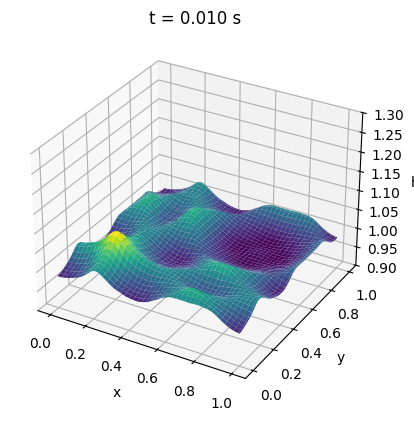

In [20]:
# Simulación
h, u, v = initial_conditions(1)
h0 = h[0].clone().numpy()
print("h0.shape:", h0.shape)
frames = []

for t in range(30000):
    h, u, v = step(h, u, v)
    if t % 300 == 0:
        frames.append(h[0].clone().numpy())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X_np = X.numpy()
Y_np = Y.numpy()

def update(frame_idx):
    ax.clear()
    ax.set_zlim(0.9, 1.3)
    ax.set_title(f"t = {frame_idx * 10 * dt:.3f} s")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("h")
    return ax.plot_surface(X_np, Y_np, frames[frame_idx], cmap='viridis')

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=50)
ani.save("shallow_water_solution.gif", writer="pillow", fps=30)
plt.show()


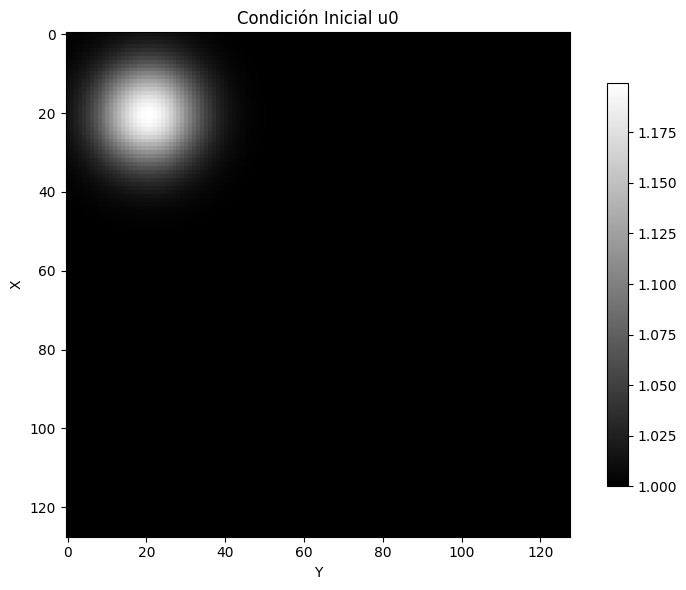

In [ ]:
# Visualizar Condición Inicial
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

im = ax.imshow(h0, cmap="gray")

ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_title('Condición Inicial u0')

fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

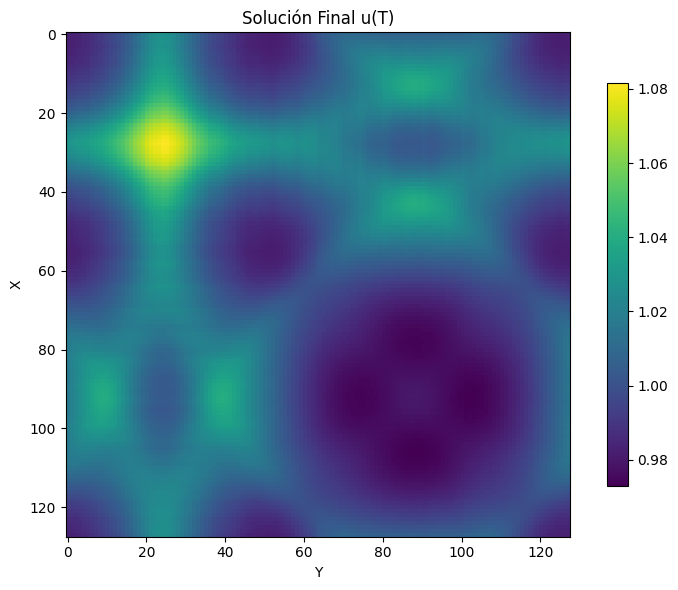

In [ ]:
# Visualizar Solución Final
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

im = ax.imshow(h[0].clone().numpy(), cmap="viridis") 


ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_title('Solución Final u(T)')


fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()